In [1]:
# Import necessary libraries
using Catlab, Catlab.Programs, Catlab.Doctrines, 
      Catlab.WiringDiagrams;

using AlgebraicRelations.QueryLib, AlgebraicRelations.SQL, AlgebraicRelations.Interface;

┌ Info: Precompiling AlgebraicRelations [1c3ea84b-a956-4dfe-a2f4-485757f48f1d]
└ @ Base loading.jl:1273


## Define the Schema
We need to define the data types, the table column names, and the syntax of our schema

In [2]:
# Data Types
types  = Dict(:full_name => (["first", "last"],[String,String]),
              :person    => (["id"], [Int]),
              :X         => ([], [Int]),
              :F         => ([], [Float64]),
              :ID        => (["id"], [Int]))

# Tables -> Column names
tables = Dict(:names     => (["person"], ["full_name"]),
              :employees => (["person"],["ID"]),
              :customers => (["person"],["ID"]),
              :manager   => (["person"],["manager"]),
              :salary    => (["person"],["salary"]),
              :relation  => (["person1", "person2"], ["relationship"]))

# Define Type Syntax
full_name = Ob(FreeBicategoryRelations, :full_name);
person = Ob(FreeBicategoryRelations, :person);
X = Ob(FreeBicategoryRelations, :X);
F = Ob(FreeBicategoryRelations, :F);
ID = Ob(FreeBicategoryRelations, :ID);

# Define Table Syntax
names = Hom(:names, person, full_name);
employees = Hom(:employees, person, ID);
customers = Hom(:customers, person, ID);
manager = Hom(:manager, person, person);
salary = Hom(:salary, person, F);
relation = Hom(:relation, person⊗person, F)

syn_types  = [full_name, person, X, F, ID];
syn_tables = [names, employees, customers, manager, salary, relation];

## Generate the Query
There are two methods of generating queries at the moment. 

The first is to write out an algebraic formula from the `Ob`s and `Hom`s just defined.

The second is to define a program using the current tables and objects as functions and types respectively.

SELECT t4.person, t5.salary
FROM manager AS t4, salary AS t5
WHERE t4.person=t5.person AND t4.manager=t4.person;


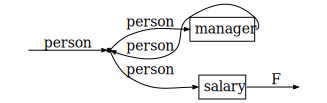

In [4]:
# Algebraic Formula Method

formula = mcopy(person)⋅(id(person)⊗manager)⋅mmerge(person)⋅salary
q = Query(types, tables, formula)
println(sql(q))
draw_query(q)

SELECT t3.person, t4.salary
FROM manager AS t3, salary AS t4
WHERE t3.person=t4.person AND t3.manager=t4.person;


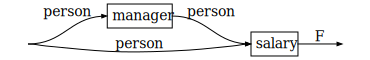

In [7]:
# Program Method

schema = to_presentation(syn_types, syn_tables)

f = @program schema (p::person) begin
  m = manager(p)
  s = salary([p,m])
  return s
end
q = Query(types, tables, f)
println(sql(q))
draw_query(q)

In [5]:
print(sql(types, tables, schema));

CREATE TYPE person AS (id int);
CREATE TYPE full_name AS (first text, last text);
-- primitive type float4;
CREATE TYPE ID AS (id int);
-- primitive type int;
CREATE TABLE manager (person person, manager person);
CREATE TABLE employees (person person, ID ID);
CREATE TABLE names (person person, full_name full_name);
CREATE TABLE customers (person person, ID ID);
CREATE TABLE salary (person person, salary float4);
CREATE TABLE relation (person1 person, person2 person, relationship float4);

In [8]:
conn = Connection("dbname=test_db");

In [8]:
# Uncomment this to initialize the tables in your database
# init_tables(conn, types, tables, schema)

In [9]:
statement = prepare(conn,q)

PostgreSQL prepared statement named __libpq__0__ with query PREPARE "__libpq__0__" (int) AS
SELECT t3.person, t3.manager
FROM manager AS t3, manager AS t4
WHERE t3.person=t4.person AND t3.manager=t4.manager AND t3.person=ROW($1);

In [10]:
execute(statement, [3])

,person,manager
,String?,String?
1,(3),(2)


In [11]:
close(conn)